In [66]:
from modules.one_hot_module import fetch_df, date_to_weekday_onehot, disability_onehot, date_to_month_onehot, specialty_ko_onehot
from modules.xgboost import XGB_module
from modules.randomForest import RF_module
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
df = fetch_df('appointment')

In [67]:
df = date_to_month_onehot(df, column_name='appointment_datetime')
df = disability_onehot(df)
df = specialty_ko_onehot(df)

{'model': LogisticRegression(), 'feature_col': ['gender', 'age', 'appointment_date_Fri', 'appointment_date_Mon', 'appointment_date_Sat', 'appointment_date_Tue', 'appointment_date_Wed', 'appointment_date_Thu', 'appointment_date_Sun'], 'target_col': 'no_show', 'train_score': 0.9025512675601486, 'test_score': 0.9047619047619048, 'train_precision': 0.0, 'train_recall': 0.0, 'train_f1': 0.0, 'test_precision': 0.0, 'test_recall': 0.0, 'test_f1': 0.0}

In [68]:
import pandas as pd

# 1) 테이블 로드
appt = fetch_df("appointment")   # appointment_date 있음
weather = fetch_df("weather")    # weather_date, average_temp_day, max_temp_day, max_rain_day 있음

# 2) 조인 키(날짜) 형식 통일 (날짜 단위로 맞춤)
appt["appointment_date"] = pd.to_datetime(appt["appointment_date"], errors="coerce").dt.normalize()
weather["weather_date"] = pd.to_datetime(weather["weather_date"], errors="coerce").dt.normalize()

# 3) weather에서 필요한 컬럼만 가져와서 날짜 기준으로 merge
weather_small = weather[["weather_date", "average_temp_day", "max_temp_day", "max_rain_day"]].drop_duplicates("weather_date")

df = appt.merge(
    weather_small,
    how="left",
    left_on="appointment_date",
    right_on="weather_date",
)

# 필요하면 조인용 컬럼 제거
df = df.drop(columns=["weather_date"])

# 4) (이미 요일 원핫을 쓰고 있다면) appointment_date를 요일 원핫으로 바꾸기
df = date_to_weekday_onehot(df, "appointment_date")

# 5) feature_col에 weather 컬럼 추가해서 ML_module에 넣기
feature_col = [
    "gender",
    "age",
    "appointment_date_Fri", "appointment_date_Mon", "appointment_date_Sat",
    "appointment_date_Sun", "appointment_date_Thu", "appointment_date_Tue",
    "appointment_date_Wed",
    "average_temp_day", "max_temp_day", "max_rain_day",
]

In [69]:
# 숫자와 불린만 남기고 object나 기타 타입은 제거
df_xgb = df.select_dtypes(include=["int64", "float64", "bool"])

# 컬럼 확인
print(df_xgb.dtypes)

appointment_id               int64
gender                       int64
age                          int64
under_12_years_old           int64
over_60_years_old            int64
patient_needs_companion      int64
no_show                      int64
average_temp_day           float64
max_temp_day               float64
max_rain_day               float64
appointment_date_Fri          bool
appointment_date_Mon          bool
appointment_date_Sat          bool
appointment_date_Sun          bool
appointment_date_Thu          bool
appointment_date_Tue          bool
appointment_date_Wed          bool
dtype: object


In [70]:
# XGB 영역

result_base = XGB_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,
    threshold=0.5
)

print("Train F1:", result_base['train_f1'])
print("Test F1 :", result_base['test_f1'])
print("Test Precision:", result_base['test_precision'])
print("Test Recall   :", result_base['test_recall'])
print("Test Score (accuracy?):", result_base['test_score'])



[INFO] scale_pos_weight 적용: 9.26
Train F1: 0.4185433787089894
Test F1 : 0.2857905982905983
Test Precision: 0.18884574655841863
Test Recall   : 0.5872667398463227
Test Score (accuracy?): 0.7303891913692276


In [71]:
print("\n=== Threshold Optimization ===")
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
for th in thresholds:
    result_th = XGB_module(
        df=df_xgb,
        target_col="no_show",
        task="classifier",
        imbalance=True,
        threshold=th
    )
    print(f"Threshold={th:.2f}, Test F1={result_th['test_f1']:.3f}, "
          f"Precision={result_th['test_precision']:.3f}, Recall={result_th['test_recall']:.3f}")



=== Threshold Optimization ===
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.40, Test F1=0.262, Precision=0.160, Recall=0.726
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.45, Test F1=0.277, Precision=0.175, Recall=0.666
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.50, Test F1=0.286, Precision=0.189, Recall=0.587
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.55, Test F1=0.288, Precision=0.203, Recall=0.493
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.60, Test F1=0.299, Precision=0.232, Recall=0.422


In [72]:
print("\n=== XGB Parameter Tuning ===")
xgb_params = {
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.05,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}
result_tuned = XGB_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,
    threshold=0.5,
    xgb_params=xgb_params
)
print("Tuned Test F1:", result_tuned['test_f1'])
print("Tuned Test Precision:", result_tuned['test_precision'])
print("Tuned Test Recall:", result_tuned['test_recall'])



=== XGB Parameter Tuning ===
[INFO] scale_pos_weight 적용: 9.26
Tuned Test F1: 0.2619745845552297
Tuned Test Precision: 0.16850047154982709
Tuned Test Recall: 0.5883644346871569


In [73]:
print("\n=== SMOTE 적용 ===")
result_smote = XGB_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,
    smote=True,
    smote_k_neighbors=5,
    threshold=0.5
)
print("SMOTE Test F1:", result_smote['test_f1'])
print("SMOTE Test Precision:", result_smote['test_precision'])
print("SMOTE Test Recall:", result_smote['test_recall'])


=== SMOTE 적용 ===
[INFO] scale_pos_weight 적용: 9.26
SMOTE Test F1: 0.2557544757033248
SMOTE Test Precision: 0.20905923344947736
SMOTE Test Recall: 0.32930845225027444


In [ ]:
model = result_smote['model']

# 1) Feature Importance
feat_names = model.feature_names_in_  # sklearn >=1.0
feat_importances = pd.Series(model.feature_importances_, index=feat_names)
# 'appointment_id' 제거
feat_importances = feat_importances.loc[[f for f in feat_names if f != 'appointment_id']]
# 높은 순서대로 정렬
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importances.plot(kind='bar')
plt.title('XGB Feature Importance (SMOTE, High to Low)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


TypeError: Cannot cast DatetimeArray to dtype float64

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC Curve (SMOTE)')
plt.legend(loc='lower right')
plt.show()



NameError: name 'y_test' is not defined

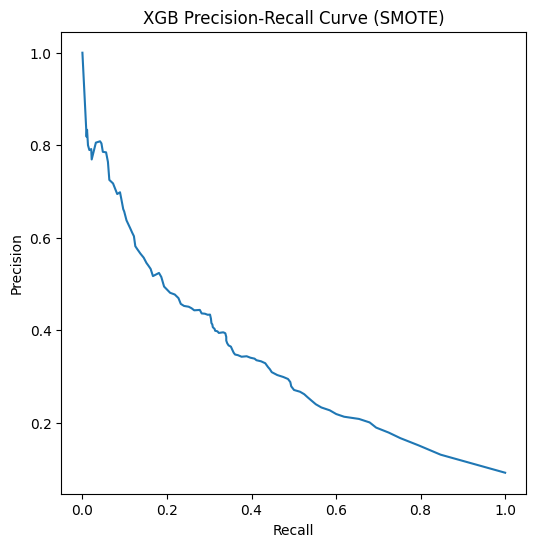

In [ ]:
# 3) Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Precision-Recall Curve (SMOTE)')
plt.show()

In [ ]:
# 랜덤포레스트 영역

drop_cols = ["appointment_datetime", "name", "entry_service_date"]

# RF baseline 실행
result_rf = RF_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,   # class_weight 적용 가능
    threshold=0.5
)

# Threshold 최적화
y_proba = result_rf['y_proba']
best_f1 = 0
best_threshold = 0.5

for t in [0.4, 0.45, 0.5, 0.55, 0.6]:
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(result_rf['y_test'], y_pred)
    print(f"Threshold={t:.2f}, Test F1={f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n최적 Threshold: {best_threshold}")

# 성능 출력
print("RF Train F1:", result_rf['train_f1'])
print("RF Test F1 :", result_rf['test_f1'])
print("RF Test Precision:", result_rf['test_precision'])
print("RF Test Recall:", result_rf['test_recall'])


Threshold=0.40, Test F1=0.358
Threshold=0.45, Test F1=0.361
Threshold=0.50, Test F1=0.351
Threshold=0.55, Test F1=0.352
Threshold=0.60, Test F1=0.327

최적 Threshold: 0.45
RF Train F1: 0.9991065730695596
RF Test F1 : 0.35081148564294634
RF Test Precision: 0.40665701881331406
RF Test Recall: 0.3084522502744237


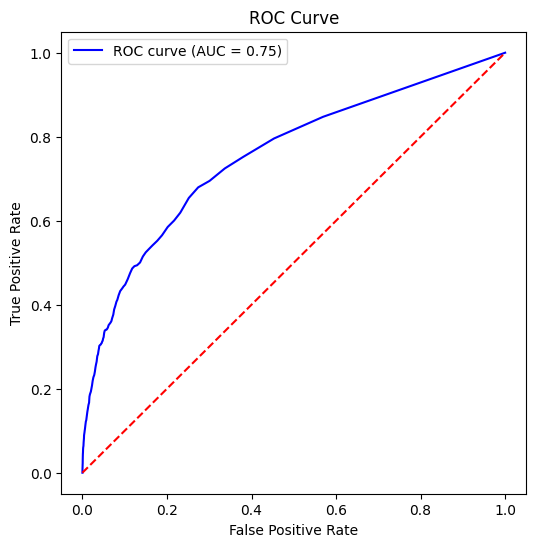

In [ ]:
y_test = result_rf['y_test']
y_proba = result_rf['y_proba']

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

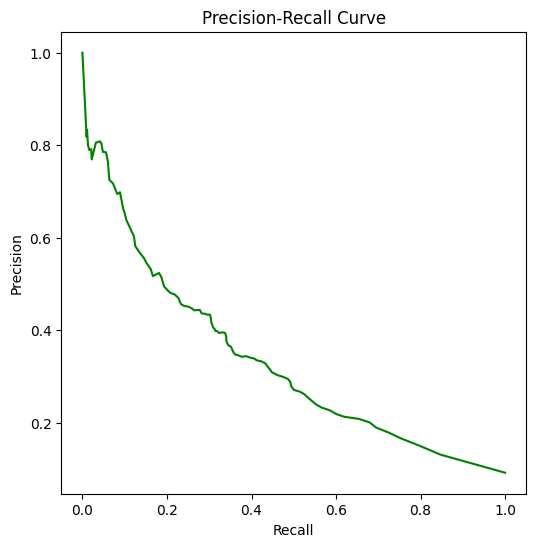

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

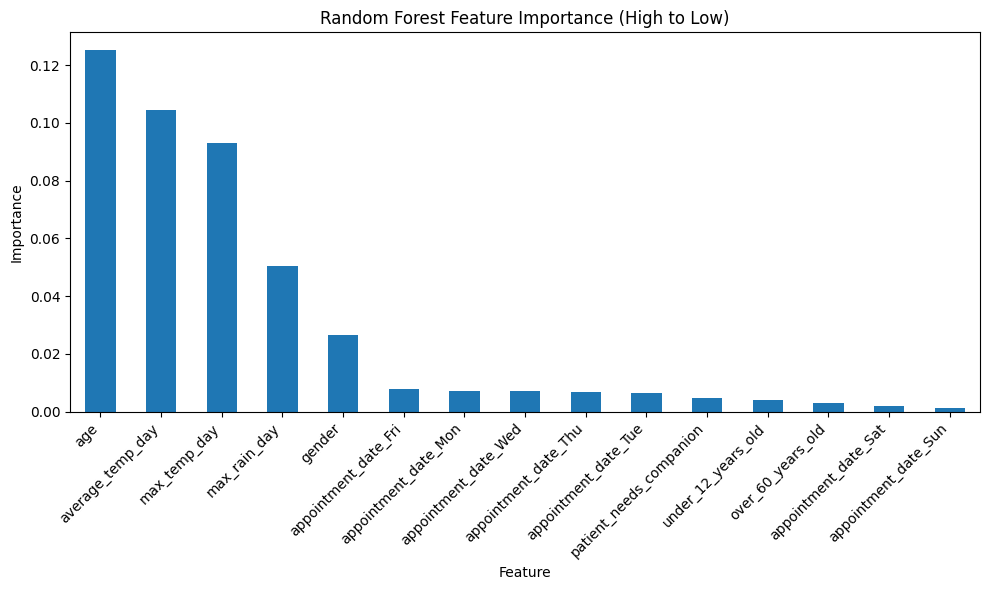

In [ ]:
model = result_rf['model']

# 실제 학습에 사용된 컬럼 확인, ID 제거
feat_names = [f for f in model.feature_names_in_ if f != 'appointment_id']

# feature importance 가져오기
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)

# ID 제거 후 높은 순으로 정렬
feat_importances = feat_importances.loc[feat_names].sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importances.plot(kind='bar')
plt.title('Random Forest Feature Importance (High to Low)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()